In [8]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
import shap

import matplotlib.pyplot as plt

# Outbreak prediction using Random Forest Experiment

Steps:
1. Split data by timestamp into training and testing set
2. Run RF model
3. Perform SHAP to get feature importance

Possible iterations: removing the static values, removing the annual values, removing both.

RandomForest in sklearn does not handle nulls, would need to remove the nulls. **In this run, the preprocessing includes:**
- Removing rows that did not contain Age statistics (Age_mean, Age_median, etc.) --- this essentially dropped the added time series rows that had no health data to them at all
- Dropped Ookla columns for now since they only match 2 years with the dataset
- RWI also removed and too many nulls --- also expected that the values would be repetitive since it is too coarse (bring back this feature if done at city level)
- population density columns are also removed for now since they contain plenty of nulls --- apparently it looks like if there are population count values in the raster, does not mean there are population density values too?

Try for next iteration:
- remove other feature
- city-level linked data?

In [9]:
PROCESSED_DIR = Path("../../data/03-processed/")
LINKED_DATA = PROCESSED_DIR / "filtered_linked_df_city_weekly_dengue.csv"

## Load dataset

In [10]:
# try filtering to check how much we have
filtered_linked_df = pd.read_csv(LINKED_DATA)
filtered_linked_df.head()

,Cases,outbreak,outbreak_group,start_of_week,CO_AVG_mean,CO_MIN_mean,CO_MAX_mean,CO_STD_mean,WEIGHTED_AVG_CO_mean,HI_AVG_mean,...,travel_time,hospital_pop_reached_total,hospital_pct_population_reached,healthcenter_pop_reached_total,healthcenter_pct_population_reached,rhu_pop_reached_total,prev_1_wk_numcases,prev_2_wk_numcases,prev_3_wk_numcases,prev_1_mo_numcases
0,0.0,0,10,2014-01-06,0.071684,0.061561,0.081937,0.007905,0.071684,27.839929,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
1,0.0,0,10,2014-01-06,0.071684,0.061561,0.081937,0.007905,0.071684,27.839929,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
2,0.0,0,10,2014-01-13,0.080858,0.069232,0.093571,0.008738,0.080858,26.511542,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
3,0.0,0,10,2014-01-20,0.081604,0.075696,0.091231,0.005616,0.081604,26.305700,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
4,0.0,0,10,2014-01-27,0.074839,0.071346,0.081812,0.004384,0.074839,26.145516,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0


In [11]:
filtered_linked_df.columns.tolist()

['Cases',
 'outbreak',
 'outbreak_group',
 'start_of_week',
 'CO_AVG_mean',
 'CO_MIN_mean',
 'CO_MAX_mean',
 'CO_STD_mean',
 'WEIGHTED_AVG_CO_mean',
 'HI_AVG_mean',
 'HI_MIN_mean',
 'HI_MAX_mean',
 'HI_STD_mean',
 'WEIGHTED_AVG_HI_mean',
 'NDVI_AVG_mean',
 'NDVI_MIN_mean',
 'NDVI_MAX_mean',
 'NDVI_STD_mean',
 'WEIGHTED_AVG_NDVI_mean',
 'NO2_AVG_mean',
 'NO2_MIN_mean',
 'NO2_MAX_mean',
 'NO2_STD_mean',
 'WEIGHTED_AVG_NO2_mean',
 'O3_AVG_mean',
 'O3_MIN_mean',
 'O3_MAX_mean',
 'O3_STD_mean',
 'WEIGHTED_AVG_O3_mean',
 'PM10_AVG_mean',
 'PM10_MIN_mean',
 'PM10_MAX_mean',
 'PM10_STD_mean',
 'WEIGHTED_AVG_PM10_mean',
 'PM25_AVG_mean',
 'PM25_MIN_mean',
 'PM25_MAX_mean',
 'PM25_STD_mean',
 'WEIGHTED_AVG_PM25_mean',
 'PR_AVG_mean',
 'PR_MIN_mean',
 'PR_MAX_mean',
 'PR_STD_mean',
 'WEIGHTED_AVG_PR_mean',
 'RH_AVG_mean',
 'RH_MIN_mean',
 'RH_MAX_mean',
 'RH_STD_mean',
 'WEIGHTED_AVG_RH_mean',
 'SO2_AVG_mean',
 'SO2_MIN_mean',
 'SO2_MAX_mean',
 'SO2_STD_mean',
 'WEIGHTED_AVG_SO2_mean',
 'SR_AVG_m

In [12]:
filtered_linked_df["start_of_week"] = pd.to_datetime(
    filtered_linked_df["start_of_week"]
)
filtered_linked_df = filtered_linked_df.sort_values(by=["start_of_week"])
filtered_linked_df.head()

,Cases,outbreak,outbreak_group,start_of_week,CO_AVG_mean,CO_MIN_mean,CO_MAX_mean,CO_STD_mean,WEIGHTED_AVG_CO_mean,HI_AVG_mean,...,travel_time,hospital_pop_reached_total,hospital_pct_population_reached,healthcenter_pop_reached_total,healthcenter_pct_population_reached,rhu_pop_reached_total,prev_1_wk_numcases,prev_2_wk_numcases,prev_3_wk_numcases,prev_1_mo_numcases
0,0.0,0,10,2014-01-06,0.071684,0.061561,0.081937,0.007905,0.071684,27.839929,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
1,0.0,0,10,2014-01-06,0.071684,0.061561,0.081937,0.007905,0.071684,27.839929,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
2,0.0,0,10,2014-01-13,0.080858,0.069232,0.093571,0.008738,0.080858,26.511542,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
3,0.0,0,10,2014-01-20,0.081604,0.075696,0.091231,0.005616,0.081604,26.305700,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
4,0.0,0,10,2014-01-27,0.074839,0.071346,0.081812,0.004384,0.074839,26.145516,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0


In [13]:
filtered_linked_df["outbreak"].value_counts()

0    317
1     47
Name: outbreak, dtype: int64

Select one baranggay

In [14]:
# filtered_linked_df = filtered_linked_df[filtered_linked_df['ADM4_PCODE']=='PH097332087']
# #all_dates = pd.date_range(start=filtered_linked_df.index.min(), end=filtered_linked_df.index.max(), freq='W-MON')
# filtered_linked_df  = filtered_linked_df.set_index(['date', 'ADM4_PCODE'])\
#             .unstack(fill_value=0)\
#             .asfreq('W-MON', fill_value=0)\
#             .stack().sort_index(level=1).reset_index()
# filtered_linked_df.head()

## Split training and testing

In [16]:
filtered_linked_df = filtered_linked_df.set_index("start_of_week")

In [17]:
filtered_linked_df

,Cases,outbreak,outbreak_group,CO_AVG_mean,CO_MIN_mean,CO_MAX_mean,CO_STD_mean,WEIGHTED_AVG_CO_mean,HI_AVG_mean,HI_MIN_mean,...,travel_time,hospital_pop_reached_total,hospital_pct_population_reached,healthcenter_pop_reached_total,healthcenter_pct_population_reached,rhu_pop_reached_total,prev_1_wk_numcases,prev_2_wk_numcases,prev_3_wk_numcases,prev_1_mo_numcases
start_of_week,,,,,,,,,,,,,,,,,,,,,
2014-01-06,0.0,0,10,0.071684,0.061561,0.081937,0.007905,0.071684,27.839929,26.642277,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
2014-01-06,0.0,0,10,0.071684,0.061561,0.081937,0.007905,0.071684,27.839929,26.642277,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
2014-01-13,0.0,0,10,0.080858,0.069232,0.093571,0.008738,0.080858,26.511542,25.750594,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
2014-01-20,0.0,0,10,0.081604,0.075696,0.091231,0.005616,0.081604,26.305700,25.304653,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
2014-01-27,0.0,0,10,0.074839,0.071346,0.081812,0.004384,0.074839,26.145516,25.773960,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,0.0,0,20,0.064094,0.059018,0.071787,0.004241,0.064094,29.145997,28.422970,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,5.0,1.0,1.0
2020-11-30,0.0,0,20,0.073589,0.060608,0.082439,0.008929,0.073589,29.262999,27.966337,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,5.0,1.0
2020-12-07,5.0,0,20,0.062223,0.059087,0.068834,0.003309,0.062223,29.446082,28.558119,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,5.0


In [18]:
# split features and target label
X = filtered_linked_df.drop(labels=["outbreak", "Cases"], axis=1)
y = filtered_linked_df["outbreak"]

In [19]:
tss = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [20]:
len(X_train), len(X_test)

(273, 91)

In [21]:
y_train.value_counts()

0    240
1     33
Name: outbreak, dtype: int64

In [22]:
y_test.value_counts()

0    77
1    14
Name: outbreak, dtype: int64

In [23]:
# length of training data
X_train.index.min(), X_train.index.max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2019-03-25 00:00:00'))

In [24]:
# length of testing data
X_test.index.min(), X_test.index.max()

(Timestamp('2019-04-01 00:00:00'), Timestamp('2020-12-21 00:00:00'))

In [25]:
X_test

,outbreak_group,CO_AVG_mean,CO_MIN_mean,CO_MAX_mean,CO_STD_mean,WEIGHTED_AVG_CO_mean,HI_AVG_mean,HI_MIN_mean,HI_MAX_mean,HI_STD_mean,...,travel_time,hospital_pop_reached_total,hospital_pct_population_reached,healthcenter_pop_reached_total,healthcenter_pct_population_reached,rhu_pop_reached_total,prev_1_wk_numcases,prev_2_wk_numcases,prev_3_wk_numcases,prev_1_mo_numcases
start_of_week,,,,,,,,,,,,,,,,,,,,,
2019-04-01,14,0.071345,0.067695,0.075829,0.002896,0.071345,29.361429,28.829109,29.965644,0.453012,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
2019-04-08,14,0.064336,0.060724,0.073297,0.004427,0.064336,30.238642,29.598911,30.781683,0.383098,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
2019-04-15,14,0.065662,0.062378,0.067407,0.002146,0.065662,29.963437,29.539703,30.323762,0.292563,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
2019-04-22,15,0.066490,0.064849,0.068458,0.001283,0.066490,31.557666,30.813267,31.924257,0.419398,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,0.0
2019-04-29,15,0.062058,0.060388,0.065372,0.001782,0.062058,30.214356,29.596832,30.998020,0.536040,...,5,124434.91,14.46,456862.05,53.09,301674.11,90.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,20,0.064094,0.059018,0.071787,0.004241,0.064094,29.145997,28.422970,30.061089,0.592359,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,5.0,1.0,1.0
2020-11-30,20,0.073589,0.060608,0.082439,0.008929,0.073589,29.262999,27.966337,29.925149,0.717179,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,5.0,1.0
2020-12-07,20,0.062223,0.059087,0.068834,0.003309,0.062223,29.446082,28.558119,30.102475,0.606429,...,5,124434.91,14.46,456862.05,53.09,301674.11,0.0,0.0,0.0,5.0


## Run RF Regressor

In [26]:
regressor = RandomForestRegressor(random_state=42)

In [27]:
param_grid = {
    "n_estimators": [50, 100, 200, 300, 500],
    "max_depth": [None, 5, 10, 15, 20],
}

In [28]:
model_grid_search = GridSearchCV(regressor, param_grid, verbose=1, cv=3)
model_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 5, 10, 15, 20],
                         'n_estimators': [50, 100, 200, 300, 500]},
             verbose=1)

In [29]:
print(f"Best hyperparameters: {model_grid_search.best_params_}")
print(f"Train best score: {model_grid_search.best_score_:0.4}")
print(
    f"Train best score std: {np.std(model_grid_search.cv_results_['mean_test_score']):0.4}"
)

Best hyperparameters: {'max_depth': None, 'n_estimators': 50}
Train best score: -0.1897
Train best score std: 0.0


In [30]:
test_score = model_grid_search.score(X_test, y_test)
print(f"Test best score: {test_score:0.6}")

Test best score: 0.243704


In [31]:
# Evaluate the model on test data
best_rf_regressor_model = model_grid_search.best_estimator_
test_accuracy = best_rf_regressor_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.2437038961038962


### Check Results

In [32]:
# Make predictions on the test set
y_pred = best_rf_regressor_model.predict(X_test)
pred_results = pd.DataFrame(y_pred)
pred_results.describe()

,0
count,91.000000
mean,0.214066
std,0.244704
min,0.000000
25%,0.070000
50%,0.100000
75%,0.280000
max,0.980000


In [33]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(
    f"""
    R2-score: {r2} \n
    MAE: {mae} \n
    MSE: {mse} \n
    RMSE: {rmse} \n
"""
)


    R2-score: 0.2437038961038962 

    MAE: 0.20747252747252745 

    MSE: 0.09845274725274722 

    RMSE: 0.31377180761302825 




Check feature importance

In [34]:
explainer = shap.Explainer(best_rf_regressor_model)
shap_values = explainer.shap_values(X_test)

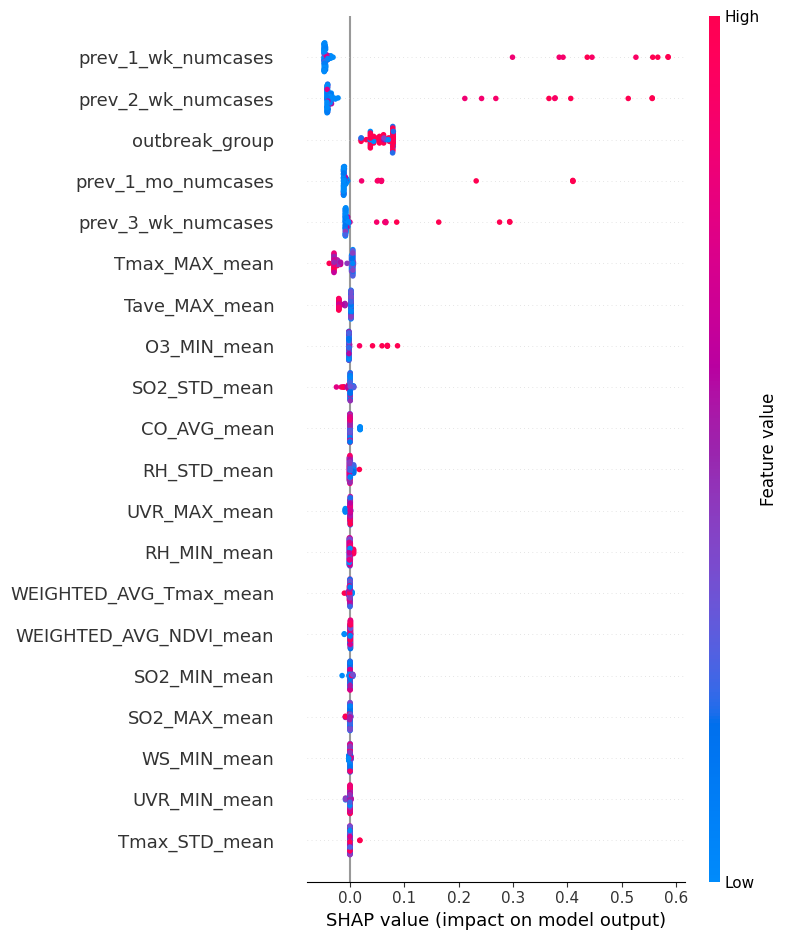

In [35]:
shap.summary_plot(shap_values, X_test)

## RF Classifier

In [36]:
classifier = RandomForestClassifier(random_state=42)

In [37]:
param_grid = {
    "n_estimators": [50, 100, 200, 300, 500],
    "max_depth": [None, 5, 10, 15, 20],
}

In [38]:
model_grid_search = GridSearchCV(classifier, param_grid, verbose=1, cv=5)
model_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 10, 15, 20],
                         'n_estimators': [50, 100, 200, 300, 500]},
             verbose=1)

In [39]:
print(f"Best hyperparameters: {model_grid_search.best_params_}")
print(f"Train best score: {model_grid_search.best_score_:0.4}")
print(
    f"Train best score std: {np.std(model_grid_search.cv_results_['mean_test_score']):0.4}"
)

Best hyperparameters: {'max_depth': None, 'n_estimators': 50}
Train best score: 0.8669
Train best score std: 0.002698


In [40]:
test_score = model_grid_search.score(X_test, y_test)
print(f"Test best score: {test_score:0.6}")

Test best score: 0.681319


In [41]:
# Evaluate the model on test data
best_rf_classifier_model = model_grid_search.best_estimator_
test_accuracy = best_rf_classifier_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.6813186813186813


### Check Results

In [42]:
# Make predictions on the test set
y_pred = best_rf_classifier_model.predict(X_test)
y_pred_proba = best_rf_classifier_model.predict_proba(X_test)
pred_results = pd.DataFrame(y_pred)
pred_results.describe()

,0
count,91.000000
mean,0.384615
std,0.489200
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [43]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(
    f"""
    R2-score: {r2} \n
    MAE: {mae} \n
    MSE: {mse} \n
    RMSE: {rmse} \n
"""
)


    R2-score: -1.4480519480519485 

    MAE: 0.31868131868131866 

    MSE: 0.31868131868131866 

    RMSE: 0.5645186610567614 




In [44]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.928571,0.675325,0.781955,77.000000
1,0.285714,0.714286,0.408163,14.000000
accuracy,0.681319,0.681319,0.681319,0.681319
macro avg,0.607143,0.694805,0.595059,91.000000
weighted avg,0.829670,0.681319,0.724448,91.000000


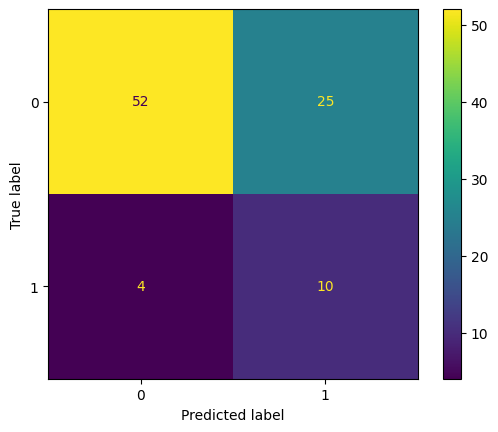

In [45]:
cm = confusion_matrix(y_test, y_pred, labels=best_rf_classifier_model.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=best_rf_classifier_model.classes_
)
disp.plot()
plt.show()

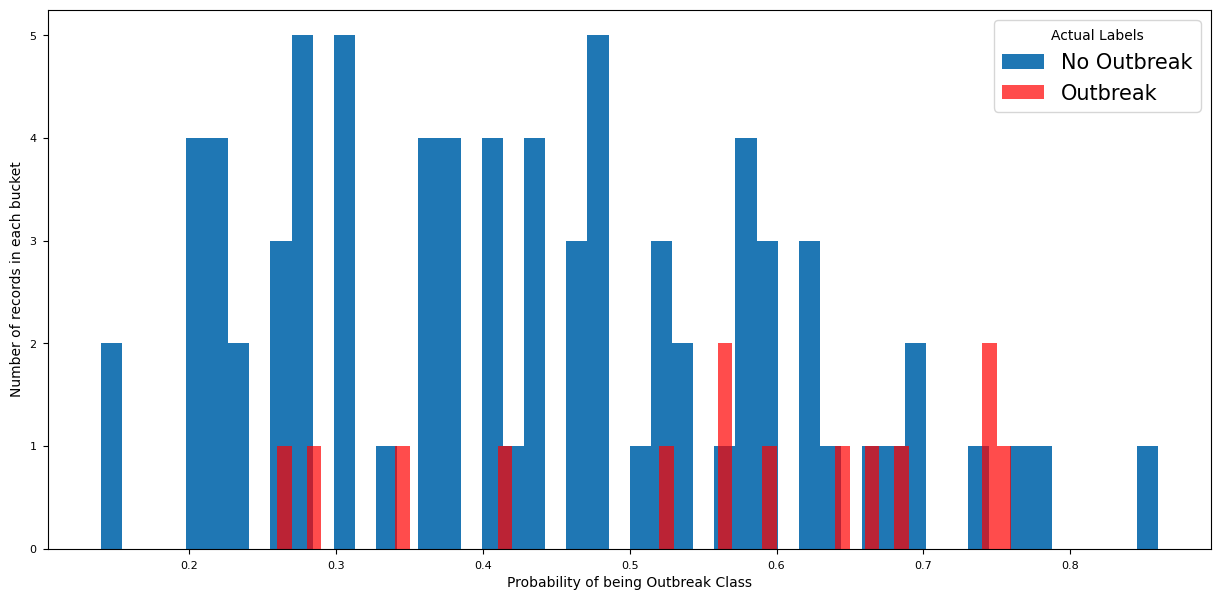

In [46]:
prediction = y_pred_proba[:, 1]  # prediction for outbreak
plt.figure(figsize=(15, 7))
plt.hist(prediction[y_test == 0], bins=50, label="No Outbreak")
plt.hist(prediction[y_test == 1], bins=50, label="Outbreak", alpha=0.7, color="r")
plt.xlabel("Probability of being Outbreak Class", fontsize=10)
plt.ylabel("Number of records in each bucket", fontsize=10)
plt.legend(fontsize=15, title="Actual Labels")
plt.tick_params(axis="both", labelsize=8, pad=5)
plt.show()

Check feature importance

In [47]:
explainer = shap.Explainer(best_rf_classifier_model)
shap_values = explainer.shap_values(X_test)

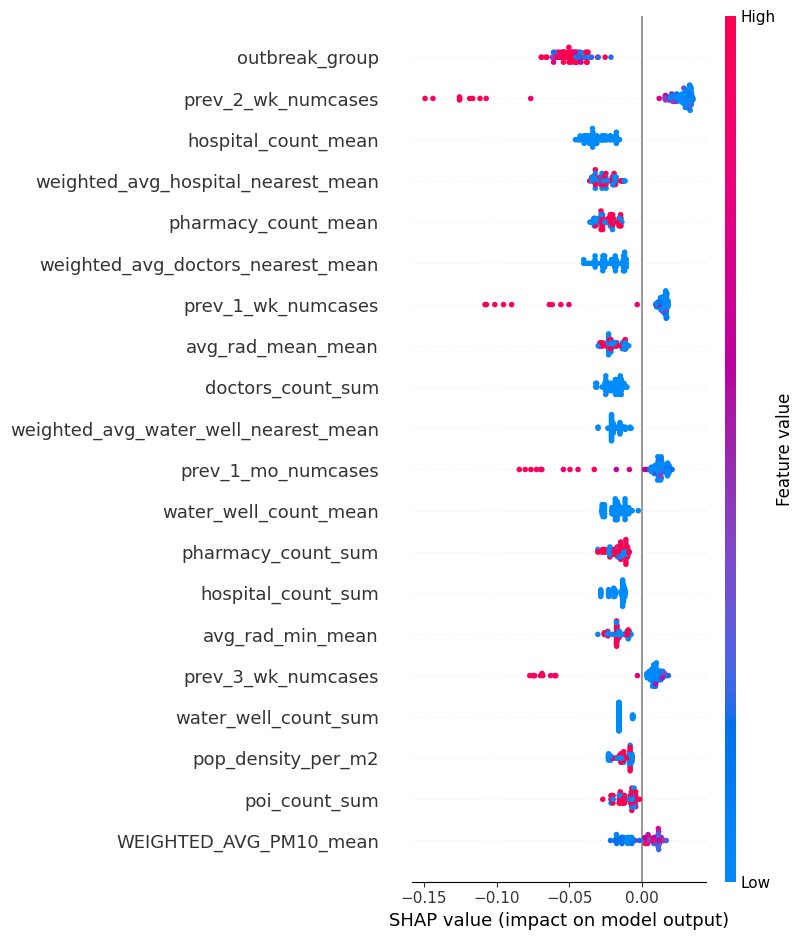

In [48]:
shap.summary_plot(shap_values[0], X_test)

## Select model to use

Add code to produce "test_dataset_for_analysis.csv" from `05-run-model-classifier.ipynb`